### Setup Connection to Database

In [ ]:
from sqlalchemy import create_engine
import pandas as pd

username = 'XXX'
password = 'XXX'
account = 'tudbfdr-bc32847'
database = 'SP_500'
schema = 'PUBLIC'
warehouse = 'COMPUTE_WH'

# Create connection string
conn_string = (
    f'snowflake://{username}:{password}@{account}/'
    f'{database}/{schema}?warehouse={warehouse}'
)

# Create engine
engine = create_engine(conn_string)

### Sector Weights of SP500

In [ ]:
query = """SELECT SYMBOL, LONGNAME, SECTOR, WEIGHT 
FROM SP500_COMPANIES"""
companies_df = pd.read_sql(query, engine)
companies_df

In [ ]:
query = """SELECT DATE, SYMBOL, CLOSE, OPEN
FROM SP500_STOCKS
WHERE Date >= '2023-01-01'"""
stocks_df = pd.read_sql(query, engine)
stocks_df

In [ ]:
mitosheet.sheet(companies_df, stocks_df, analysis_to_replay="id-eecbyuuoyc")

In [ ]:
from mitosheet.public.v3 import *; register_analysis("id-eecbyuuoyc");

# Merged companies_df and stocks_df into df_merge
temp_df = stocks_df.drop_duplicates(subset=['symbol']) # Remove duplicates so lookup merge only returns first match
df_merge = companies_df.merge(temp_df, left_on=['symbol'], right_on=['symbol'], how='left', suffixes=['_companies_df', '_stocks_df'])

# Changed weight to dtype float
df_merge['weight'] = to_float_series(df_merge['weight'])

# Pivoted df_merge into df_merge_pivot
tmp_df = df_merge[['weight', 'sector']].copy()
pivot_table = tmp_df.pivot_table(
    index=['sector'],
    values=['weight'],
    aggfunc={'weight': ['sum']}
)
pivot_table = pivot_table.set_axis([flatten_column_header(col) for col in pivot_table.keys()], axis=1)
df_merge_pivot = pivot_table.reset_index()


### Daily Returns


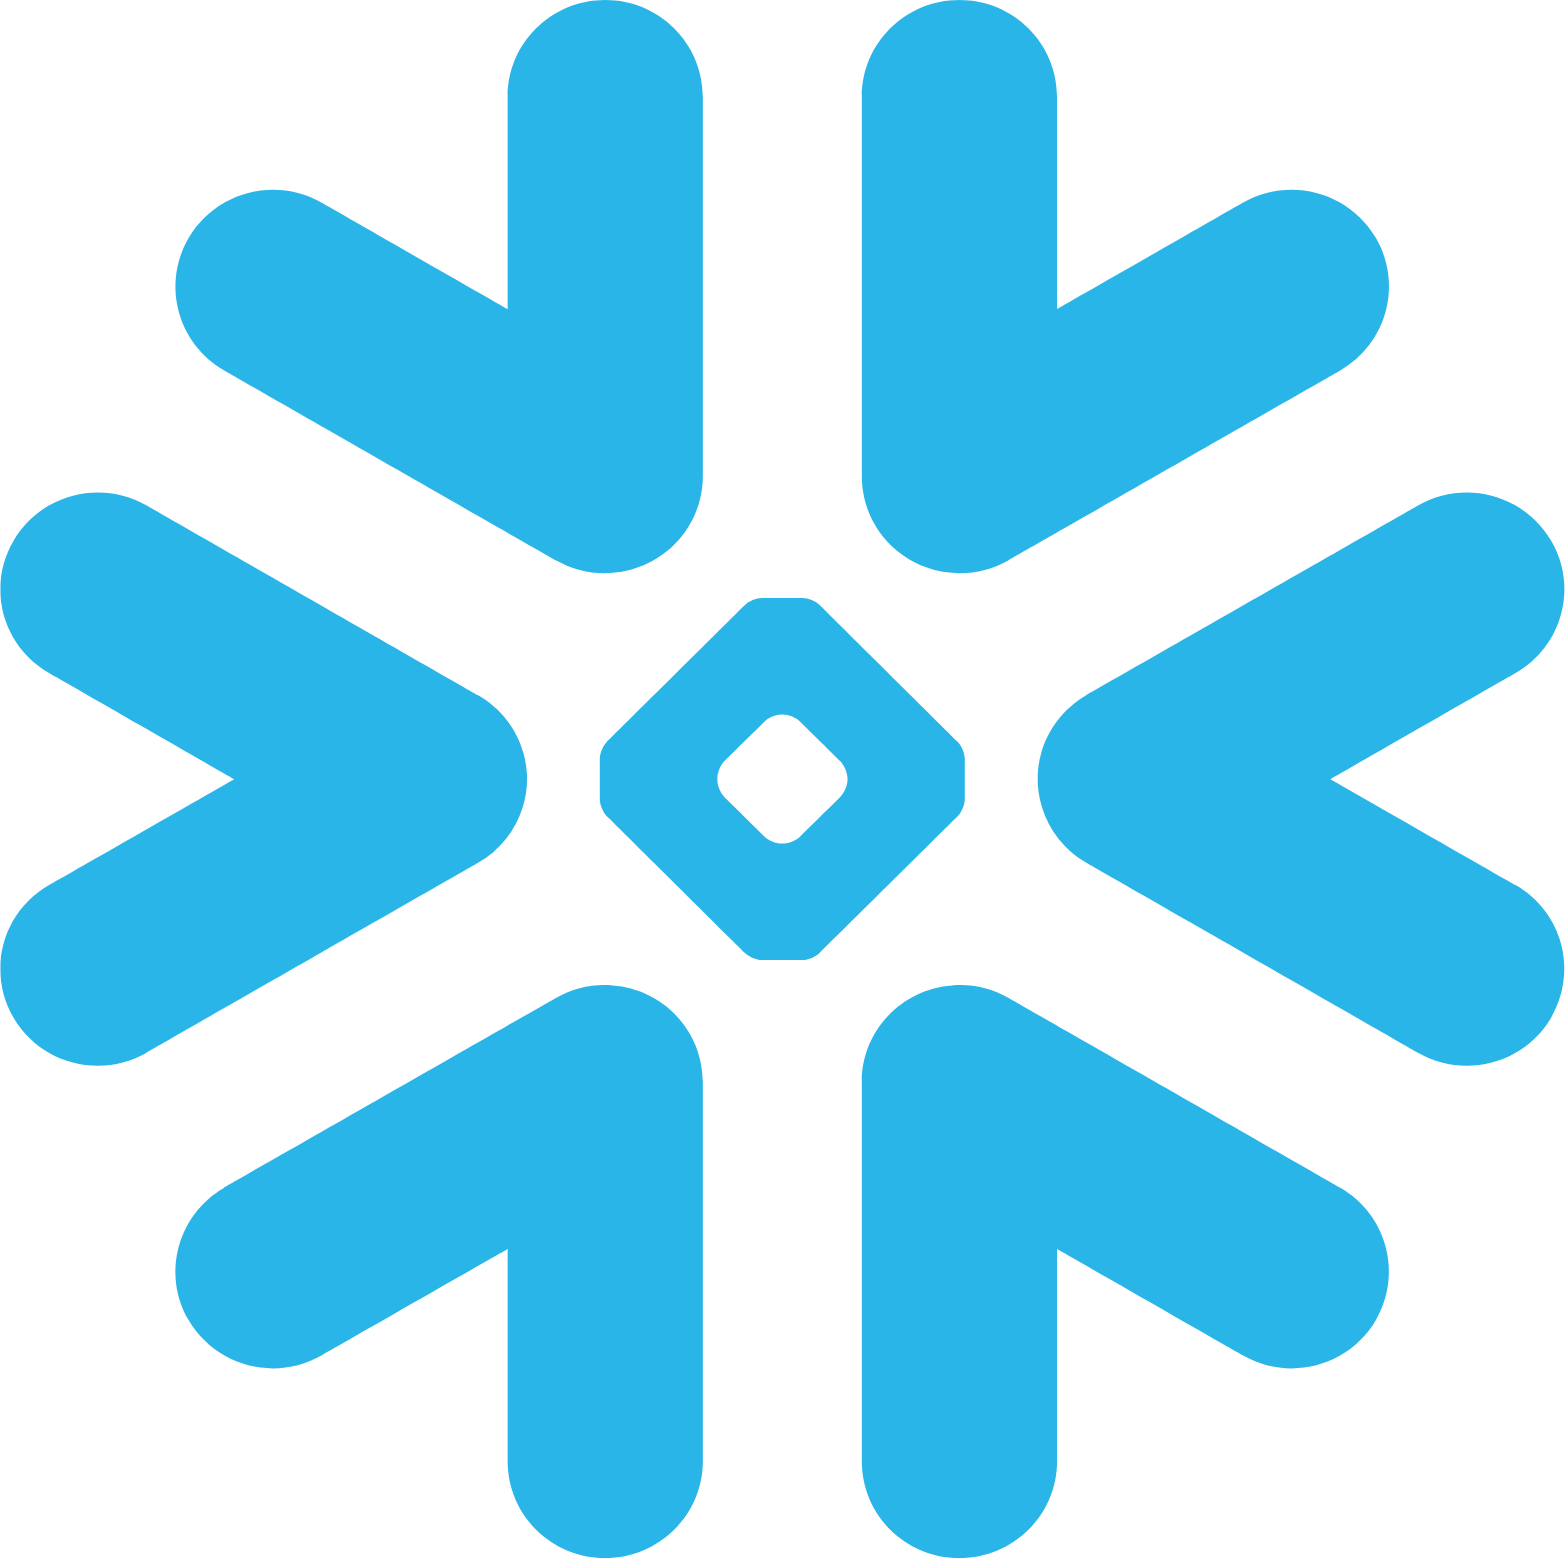

In [14]:
query = """WITH stock_symbols AS (
    SELECT symbol 
    FROM SP500_COMPANIES
)
SELECT 
    s.symbol,
    s.date,
    s.open,
    s.high,
    s.low,
    s.close,
    s.volume,
    (s.close / s.open - 1) * 100 AS daily_return_pct
FROM 
    SP500_STOCKS s
JOIN 
    stock_symbols ss ON s.symbol = ss.symbol
WHERE 
    s.date >= '2023-01-01'
ORDER BY 
    s.symbol, s.date;"""
companies_df = pd.read_sql(query, engine)
companies_df

### Risk-Adjusted Return Assessment
This analysis calculates several statistics:

- `5-day returns` to assess recent momentum, recognizing that short-term performance can signal market sentiment shifts that may precede longer-term trends.
- `Daily price volatility` is computed using standard deviation of returns, providing insight into the risk profile of each security - a crucial consideration for portfolio construction.
- `EBITDA yield` (EBITDA/Market Cap) serves as our primary valuation metric, helping identify companies that generate strong operational earnings relative to their market valuation.
- `Revenue growth rate` assessment allows us to distinguish between value traps and companies with sustainable business momentum.
- `Composite Scoring System` combines value and growth metrics to rank securities based on their overall investment potential.

In [ ]:
query = """
%%sql --configfile "/Users/aarondiamond-reivich/.mito/connections.ini" --out abc snowflake-sp500
-- First, calculate daily returns in a CTE
WITH daily_returns AS (
  SELECT 
    symbol,
    date,
    close,
    close / LAG(close) OVER (PARTITION BY symbol ORDER BY date) - 1 AS daily_return
  FROM 
    SP500_STOCKS
),

-- Then calculate aggregates including volatility
stock_metrics AS (
  SELECT 
    s.symbol,
    c.shortname,
    c.sector,
    c.industry,
    c.currentprice,
    c.ebitda / c.marketcap AS ebitda_yield,
    c.revenuegrowth,
    -- Calculate 5-day return
    (MAX(CASE WHEN s.date = (SELECT MAX(date) FROM SP500_STOCKS) THEN s.close END) /
     MIN(CASE WHEN s.date = (SELECT MIN(date) FROM SP500_STOCKS) THEN s.close END) - 1) * 100 AS five_day_return,
    -- Calculate average volume
    AVG(s.volume) AS avg_volume,
    -- Calculate volatility (standard deviation of daily returns)
    STDDEV(dr.daily_return * 100) AS daily_volatility
  FROM 
    SP500_STOCKS s
  JOIN 
    SP500_COMPANIES c ON s.symbol = c.symbol
  LEFT JOIN
    daily_returns dr ON s.symbol = dr.symbol AND s.date = dr.date
  GROUP BY 
    s.symbol, c.shortname, c.sector, c.industry, c.currentprice, 
    c.ebitda, c.marketcap, c.revenuegrowth
)

-- Finally, create the composite score
SELECT 
  symbol,
  shortname,
  sector,
  industry,
  currentprice,
  five_day_return,
  ebitda_yield * 100 AS ebitda_yield_pct,
  revenuegrowth * 100 AS revenue_growth_pct,
  avg_volume,
  daily_volatility,
  -- Create a composite score for screening
  CASE 
    WHEN ebitda_yield > 0.1 THEN 3
    WHEN ebitda_yield > 0.05 THEN 2
    WHEN ebitda_yield > 0 THEN 1
    ELSE 0
  END + 
  CASE 
    WHEN revenuegrowth > 0.2 THEN 3
    WHEN revenuegrowth > 0.1 THEN 2
    WHEN revenuegrowth > 0 THEN 1
    ELSE 0
  END AS value_growth_score
FROM 
  stock_metrics
ORDER BY 
  value_growth_score DESC, five_day_return DESC;
"""
df = pd.read_sql(query, engine)
df